In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Set-up

These values of intrinsics were found out by regressing `skeletons_image.txt` and `skeletons_world.txt` to find out the transformation matrix between $(u,v)$ and $(X_w,Y_w,Z_w)$.

In [3]:
fx, fy, cx, cy = (440.44232, -461.0357, -0.00015258789, 3.0517578e-05)

`g` - Gesture #

`f` - Finger #

`s` - Subject #

`e` - Essai #

In [5]:
g = 1
f = 1
s = 1
e = 1

ESSAI = f'./dataset/gesture_{g}/finger_{f}/subject_{s}/essai_{e}/'

In [6]:
true_uvd = np.loadtxt(f'{ESSAI}/skeletons_image.txt', dtype=np.float16)
true_xyz = np.loadtxt(f'{ESSAI}/skeletons_world.txt', dtype=np.float16)

true_uvd = true_uvd.reshape((-1, 22, 2))
true_uvd = np.delete(true_uvd, 1, 1) # 3, 4

true_xyz = true_xyz.reshape((-1, 22, 3))
true_xyz = np.delete(true_xyz, 1, 1) # 4, 5, 6

true_uvd.shape, true_xyz.shape

((95, 21, 2), (95, 21, 3))

# Inference

In [7]:
from srn import srn
handpose = srn.handpose

In [8]:
pred_xyz = handpose.run(ESSAI)

## Preprocess

Flip image coordinates
$$ u = 640 - u' $$

## Calculate world coordinates

$$ world = \frac{image}{f} Z_{world} $$
$$ image = \frac{world}{Z_{world}} f $$

In [9]:
pred_U = (pred_xyz[:,:,0] * fx / pred_xyz[:,:,2]).flatten()
pred_V = (pred_xyz[:,:,1] * fy / pred_xyz[:,:,2]).flatten()
pred_D = pred_xyz[:,:,2].flatten() * 0.00092

In [10]:
pred_X = pred_xyz[:,:,0].flatten()
pred_Y = pred_xyz[:,:,1].flatten()
pred_Z = pred_xyz[:,:,2].flatten() * 0.00092

In [11]:
true_X = true_xyz[:,:,0].flatten()
true_Y = true_xyz[:,:,1].flatten()
true_Z = true_xyz[:,:,2].flatten()
true_U = true_uvd[:,:,0].flatten()
true_V = true_uvd[:,:,1].flatten()
true_D = true_Z

## Examine

In [12]:
np.mean(np.abs(true_xyz - pred_xyz))

0.016107026

### Scaling of true depth and predicted depth
What might be the scaling? 1111 had 0.00092

In [13]:
(true_D / pred_D).mean()

1072.541

## Errors

Error in $X_w$

In [14]:
np.mean(np.abs(true_X - pred_X))

0.015248873

Error in $Y_w$

In [16]:
np.mean(np.abs(true_Y - pred_Y))

0.016844384

Error in $Z_w$

In [17]:
np.mean(np.abs(true_Z - pred_Z))

0.44892836

Error in $u$

In [18]:
np.mean(np.abs(true_U - pred_U))

7.8849816

Error in $v$

In [19]:
np.mean(np.abs(true_V - pred_V))

12.043497

## Plots

In [39]:
from srn.vis_tool import draw_pose

### Plotting pred_uvd

In [40]:
pred_UV = np.concatenate([pred_U[:,None], pred_V[:,None]], axis=1)
pred_UV = np.reshape(pred_UV, (-1, 21, 2))
pred_UV.shape

(95, 21, 2)

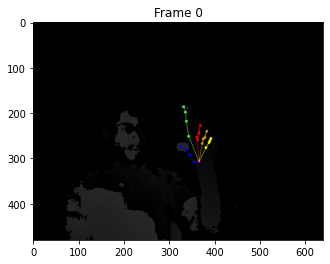

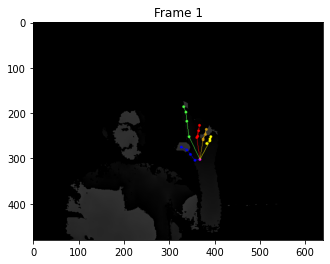

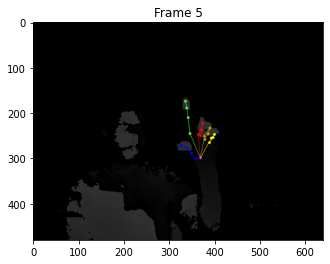

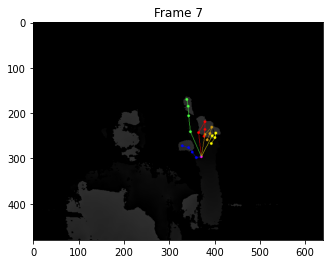

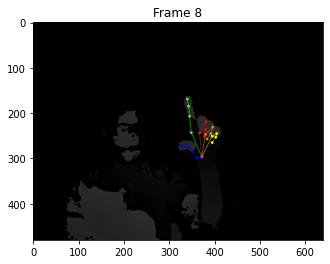

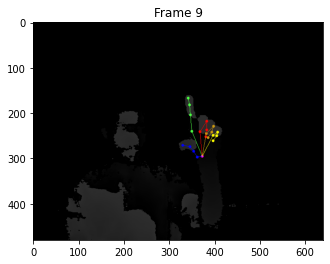

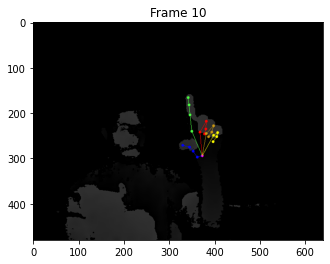

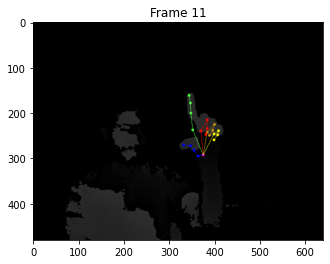

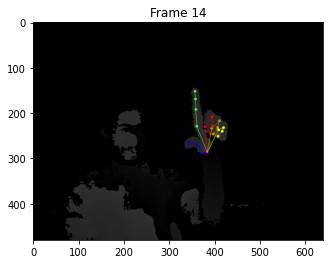

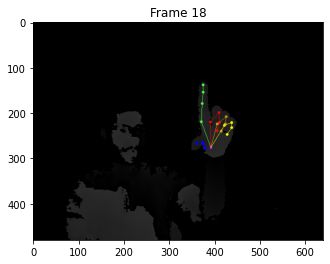

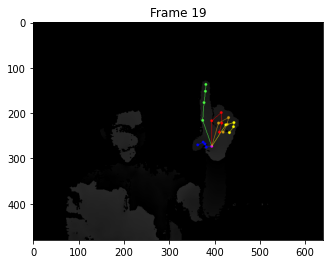

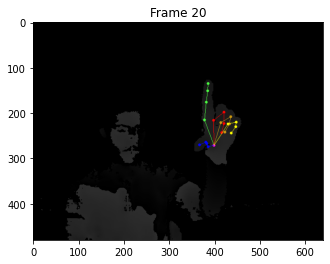

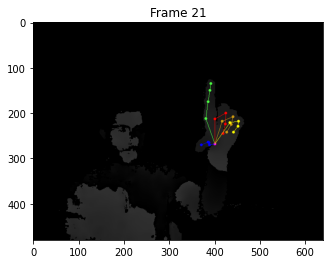

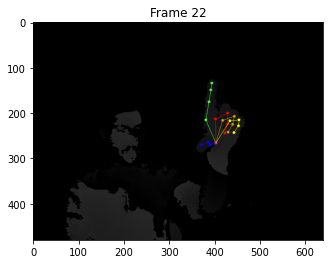

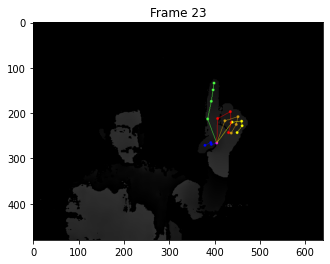

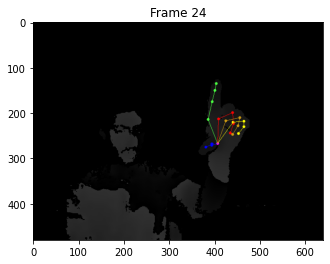

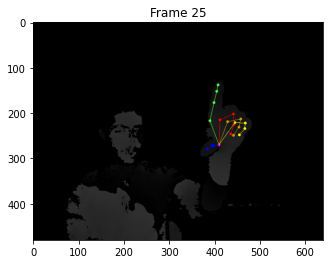

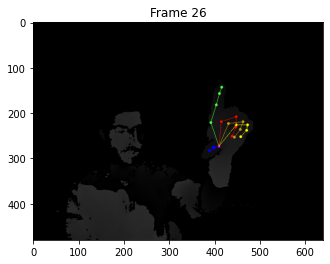

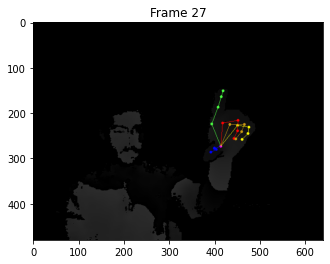

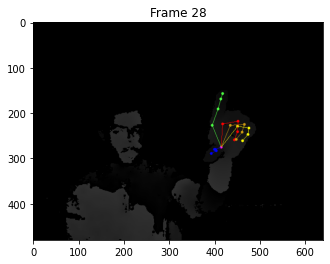

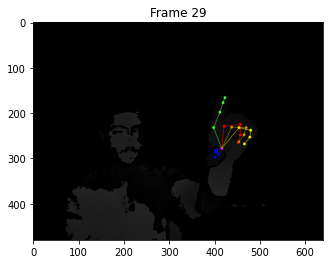

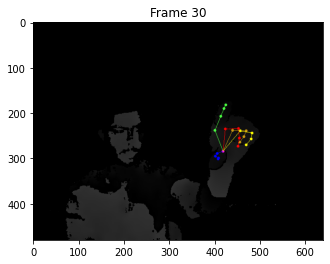

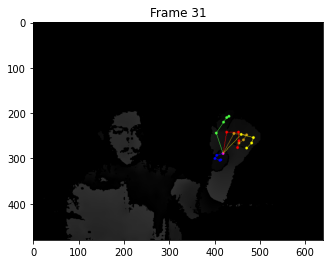

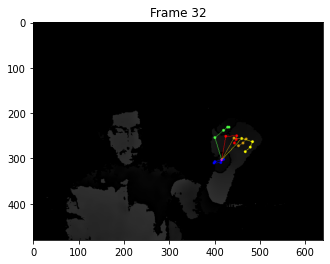

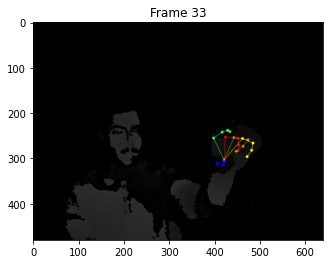

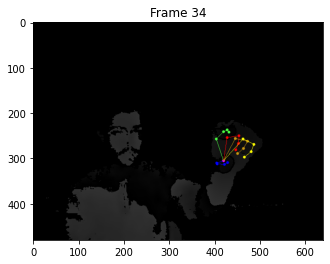

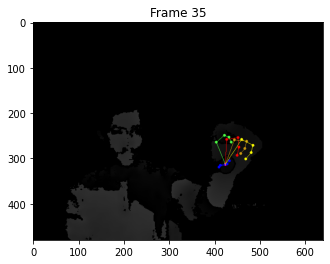

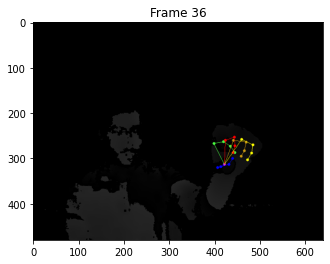

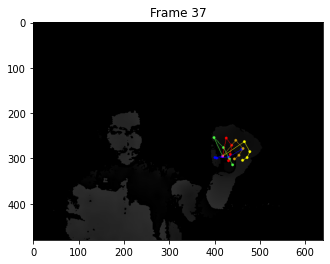

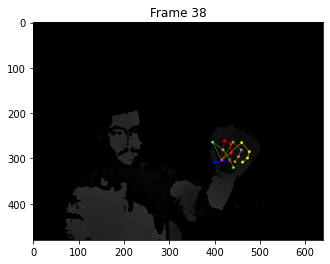

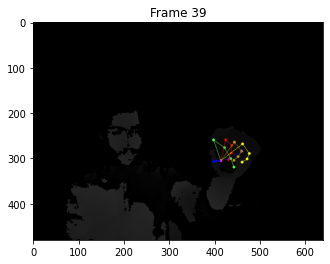

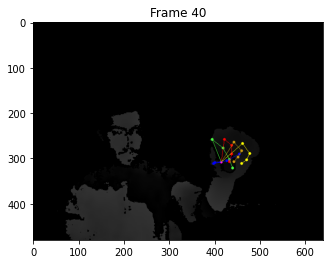

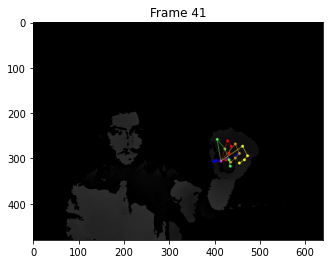

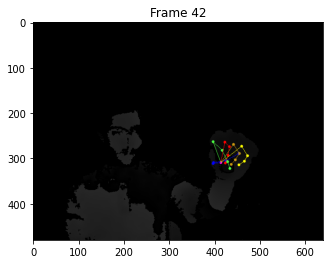

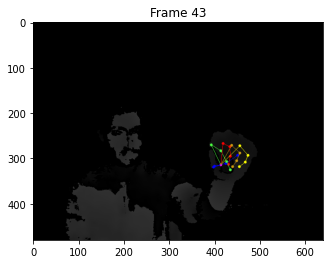

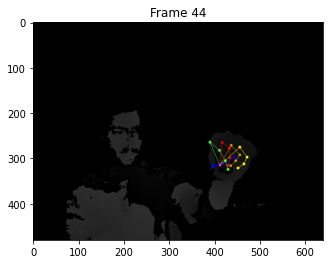

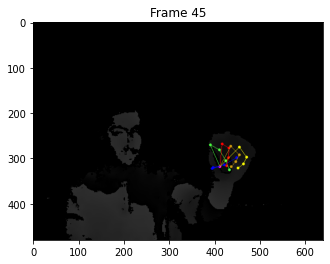

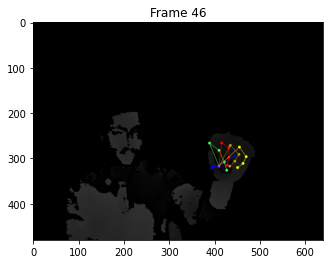

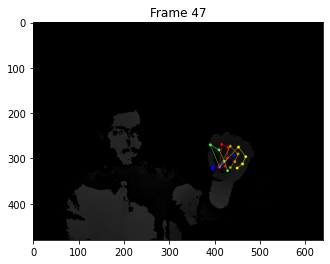

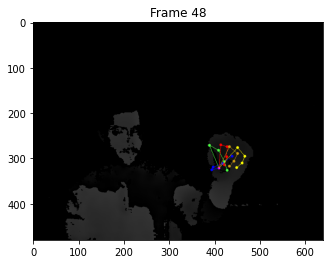

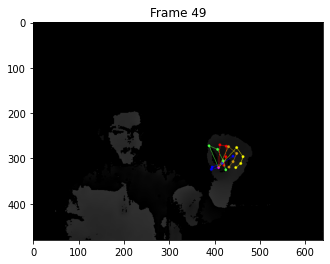

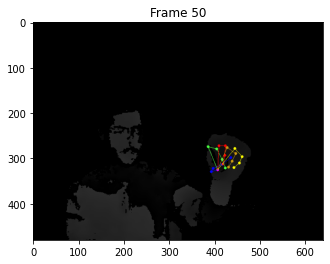

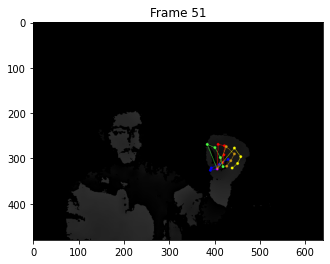

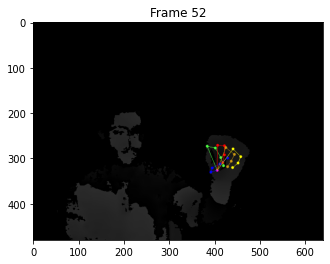

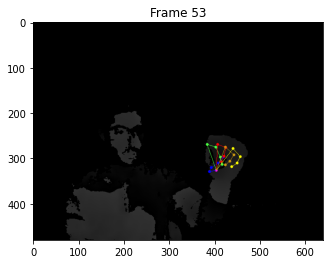

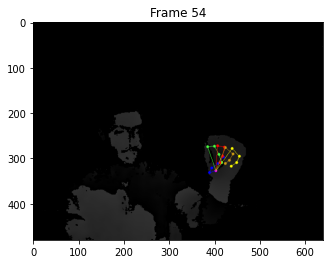

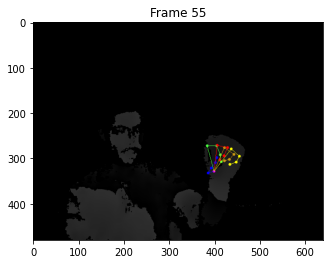

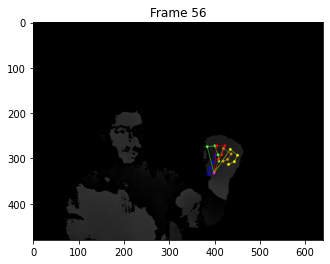

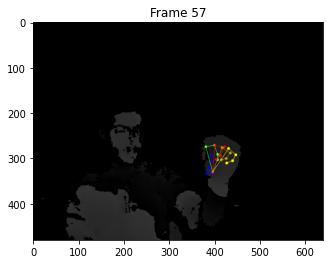

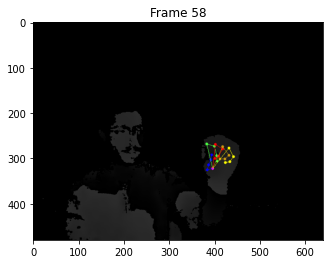

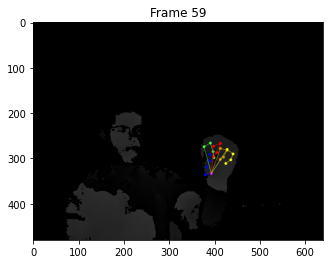

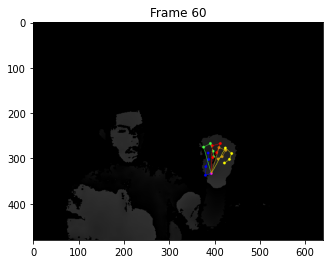

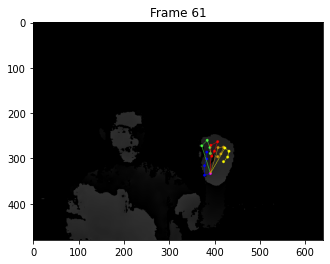

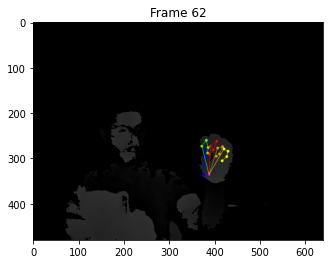

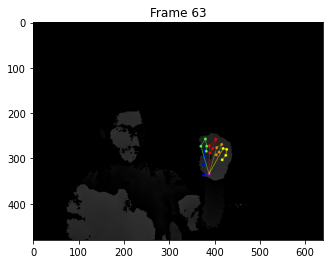

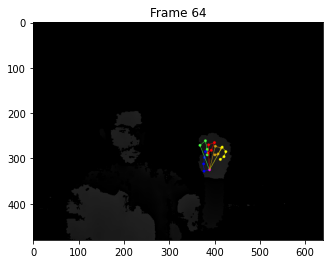

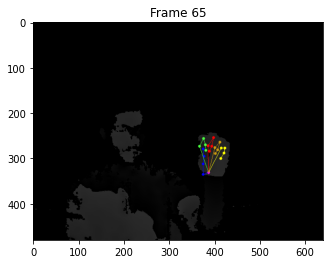

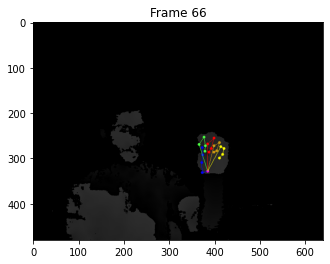

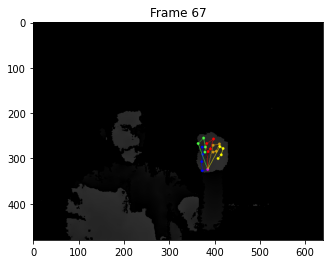

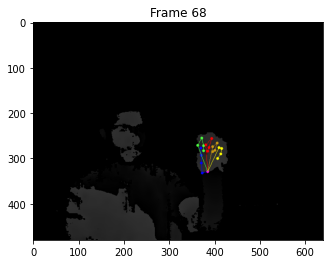

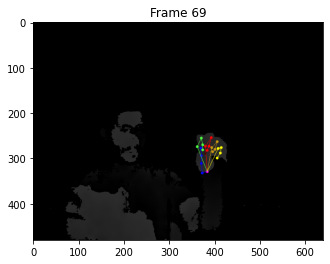

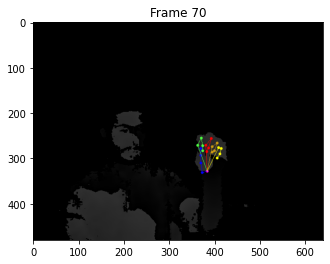

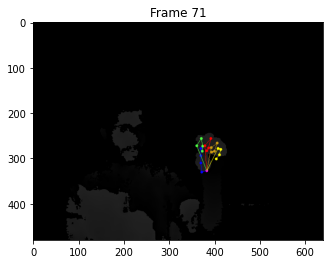

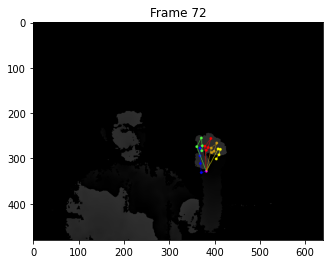

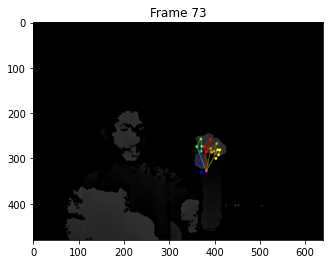

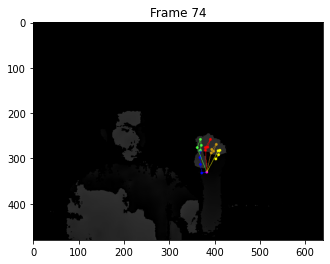

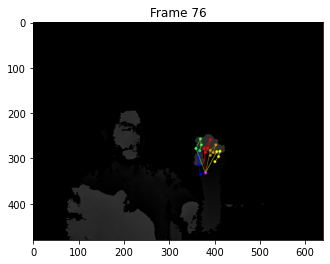

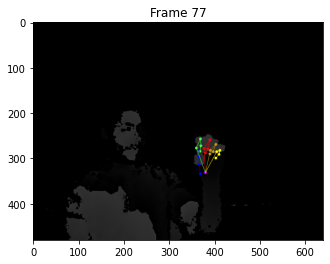

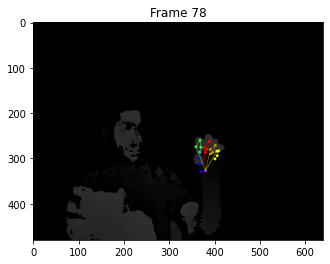

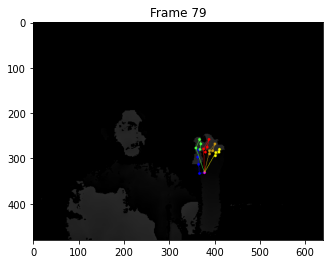

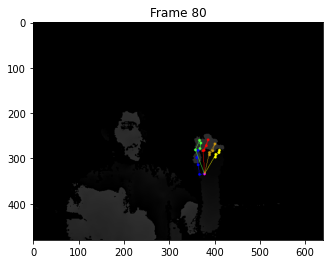

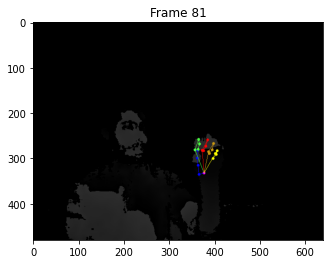

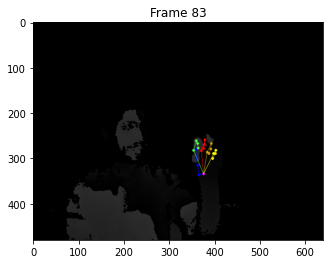

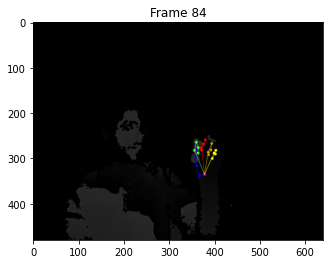

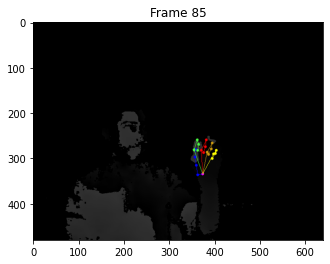

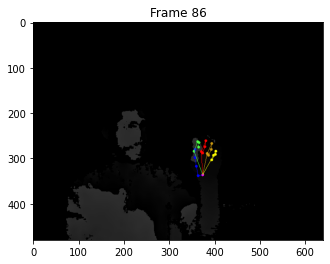

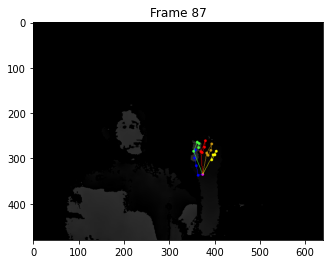

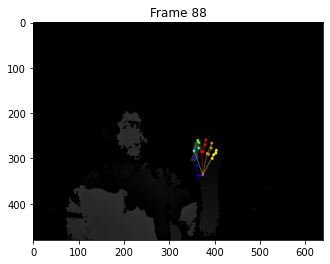

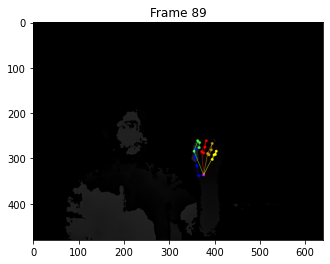

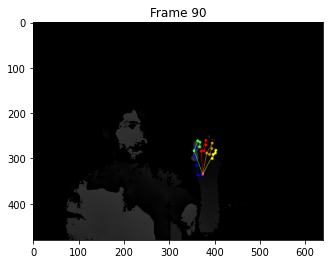

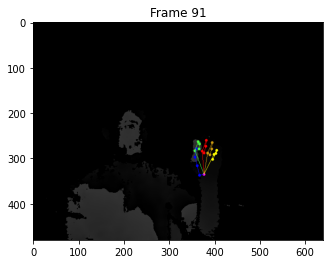

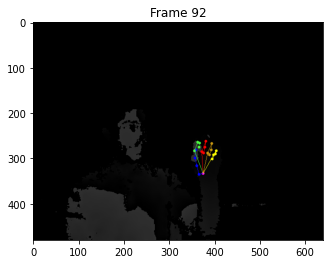

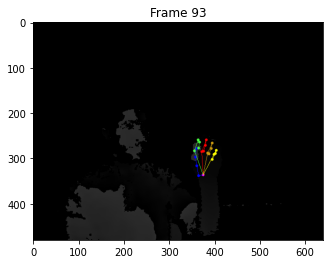

In [44]:
for frameno, poses in enumerate(pred_UV):
    img = cv2.imread(ESSAI + f'/{frameno}_depth.png', cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = (255*(img - np.min(img))/np.ptp(img)).astype(np.uint8)
    img = draw_pose("msra", img, poses)
    plt.title(f"Frame {frameno}")
    plt.imshow(img)
    plt.show()

### Plotting true_uvd

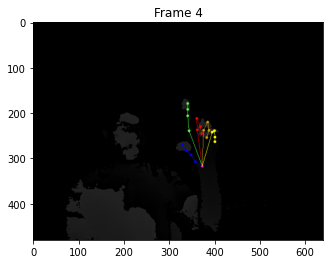

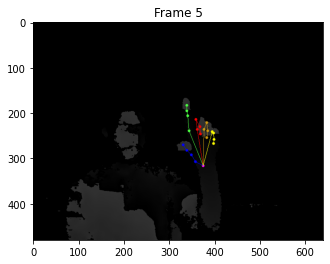

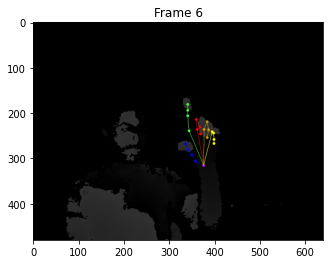

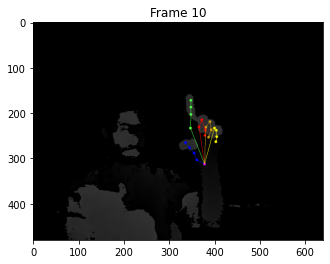

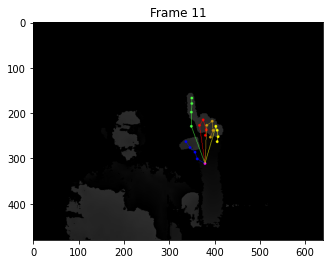

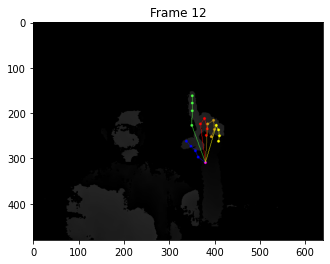

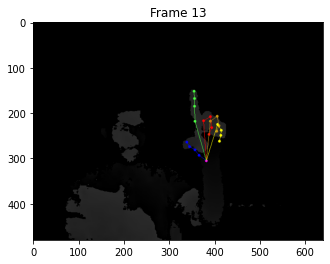

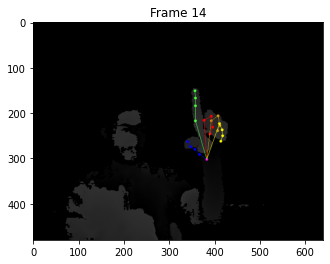

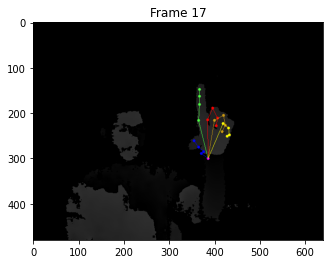

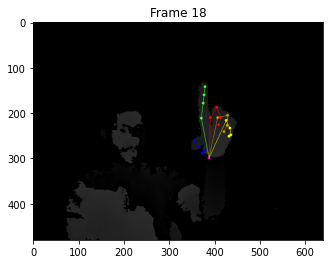

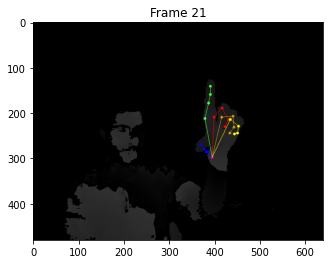

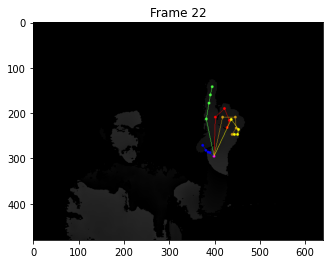

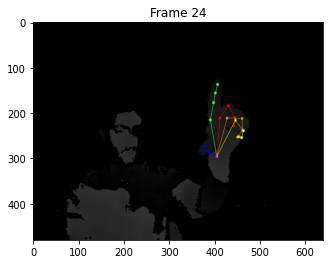

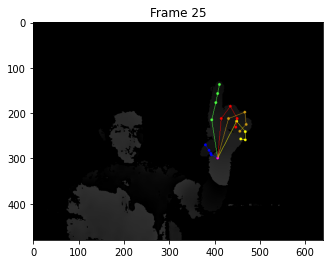

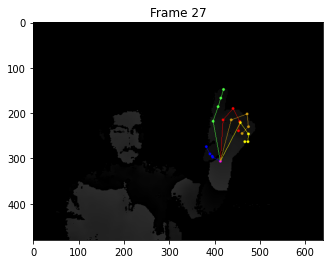

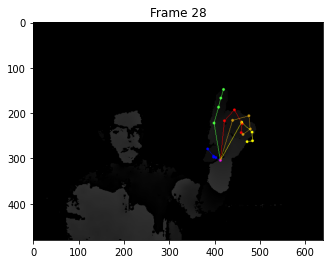

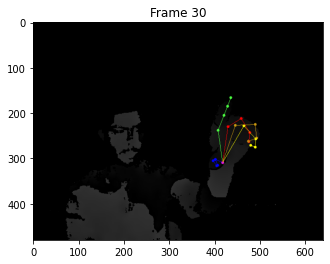

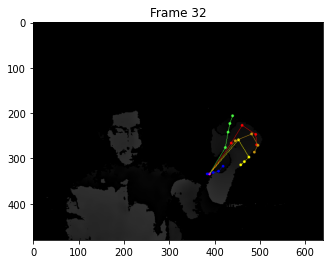

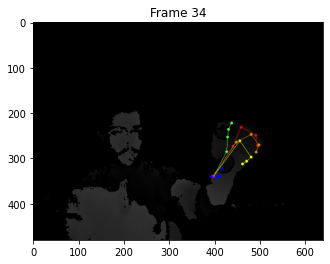

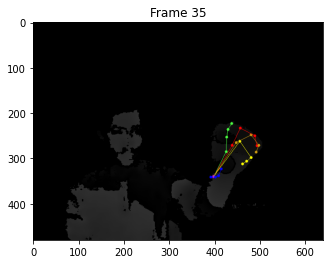

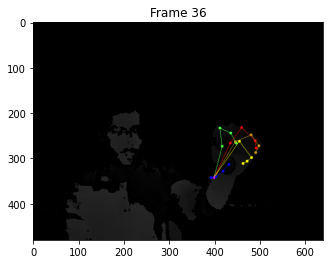

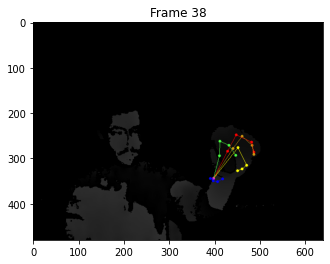

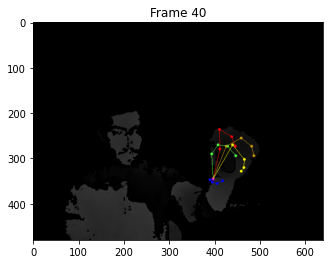

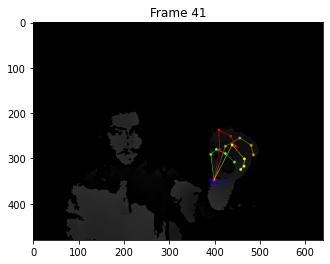

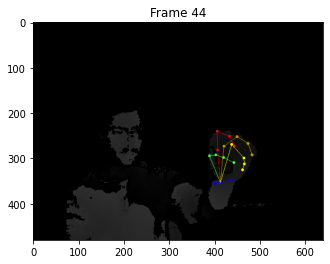

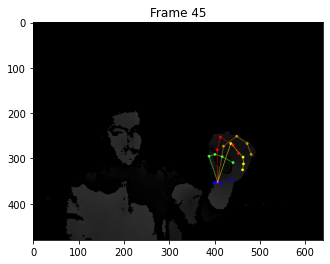

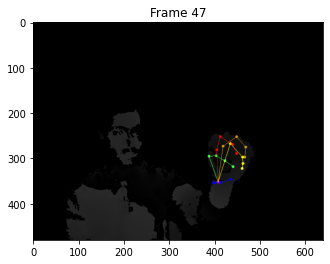

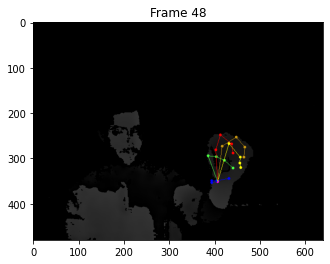

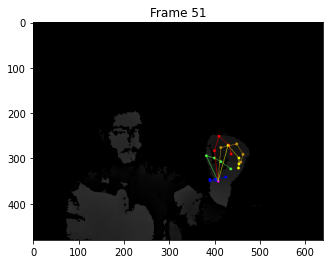

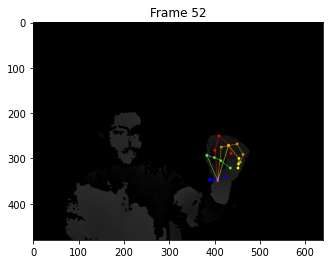

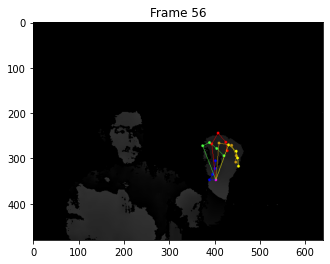

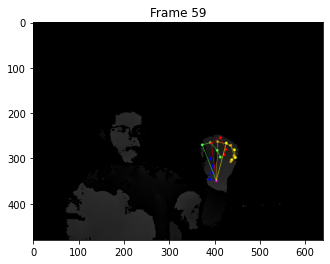

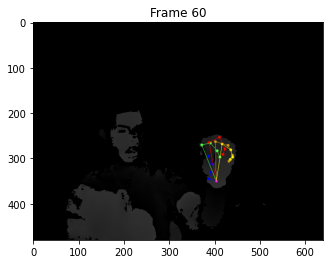

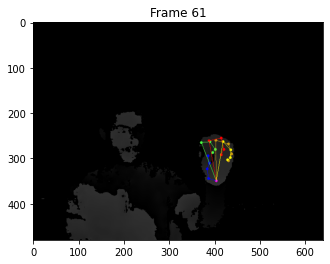

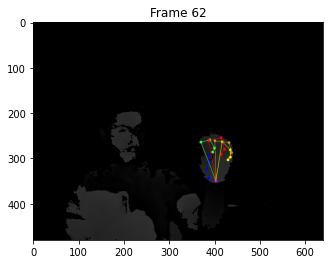

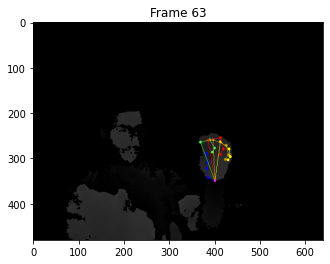

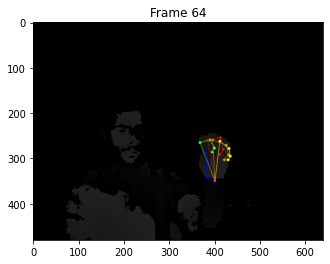

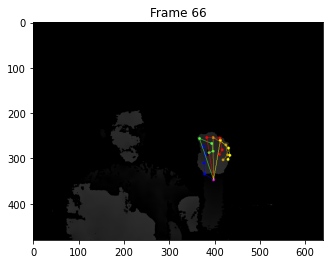

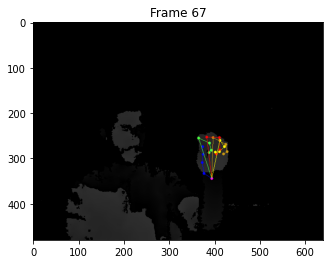

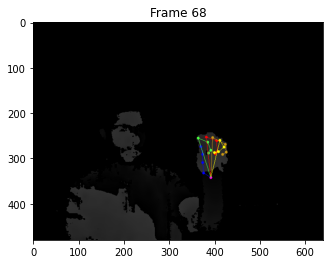

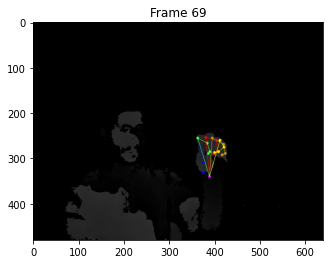

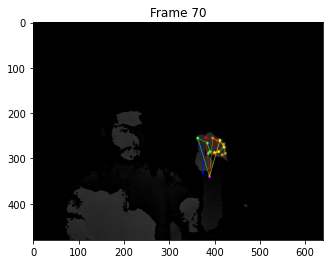

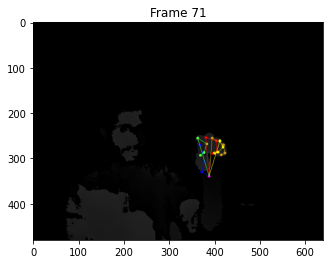

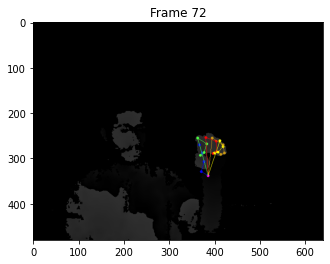

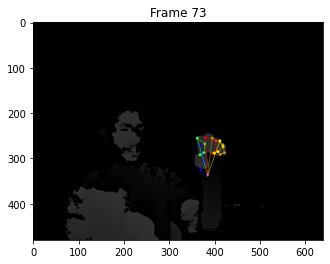

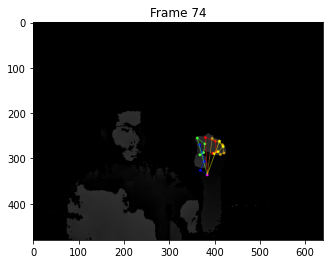

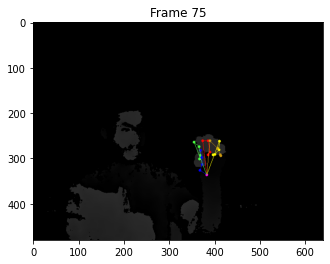

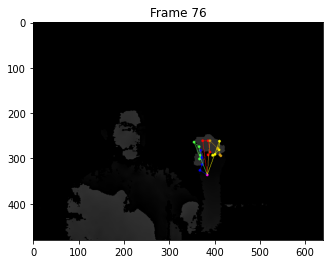

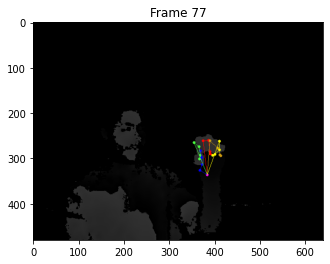

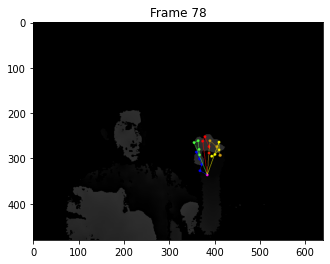

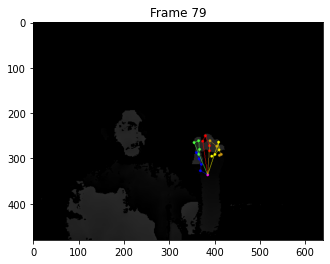

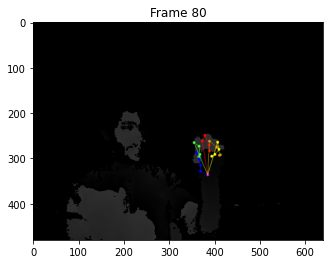

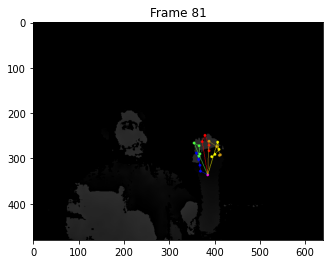

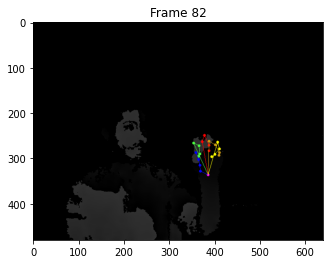

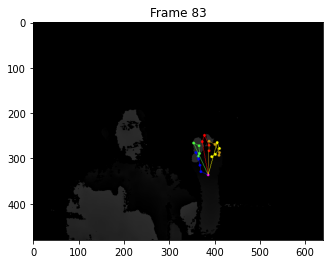

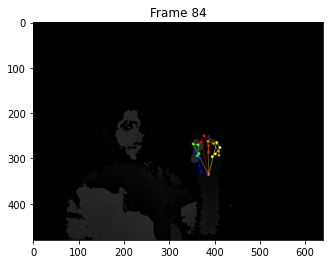

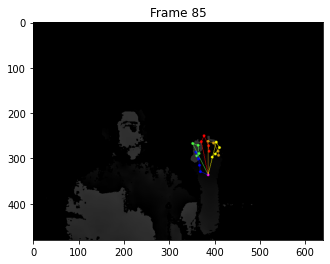

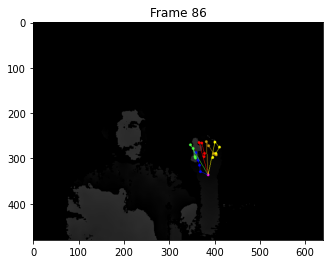

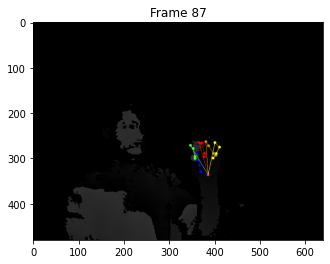

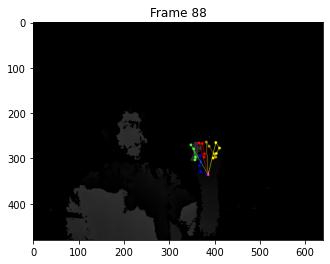

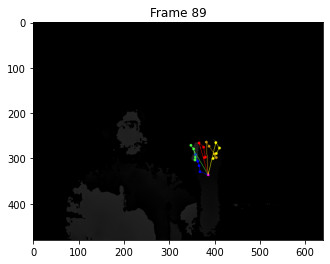

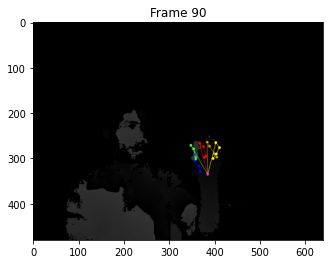

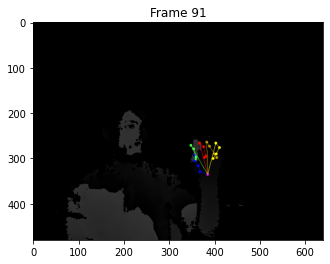

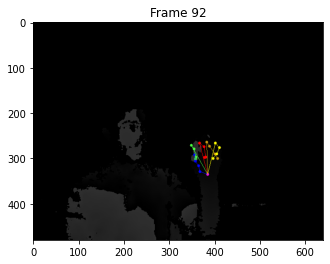

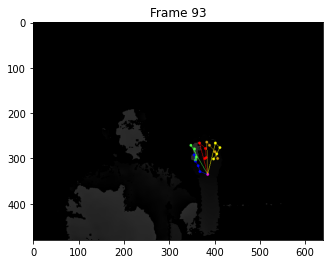

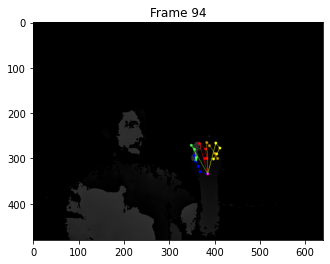

In [43]:
from srn.vis_tool import draw_pose
for frameno, poses in enumerate(true_uvd):
    img = cv2.imread(ESSAI + f'/{frameno}_depth.png', cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = (255*(img - np.min(img))/np.ptp(img)).astype(np.uint8)
    img = draw_pose("msra", img, poses)
    plt.title(f"Frame {frameno}")
    plt.imshow(img)
    plt.show()